<a href="https://colab.research.google.com/github/manu042k/Classification-of-Jute-Pest-using-Convolutional-Neural-Networks/blob/master/Jute_Pest_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing package for plotting

In [ ]:
!pip install livelossplot


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importing libraries 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from livelossplot import PlotLossesKeras


Setting required varibales 

In [ ]:
img_width = 227
img_height = 227

EPOCHS = 100
BATCH_SIZE = 32

INPUT_SHAPE = (img_width, img_height)

train_dir ='/content/drive/MyDrive/Colab Notebooks/Jute Pest/train'
test_dir ='/content/drive/MyDrive/Colab Notebooks/Jute Pest/validation'

Data preprocessing

In [ ]:
data_generator = ImageDataGenerator(
    rescale=1/255.,
    vertical_flip=True,
    horizontal_flip=True,
    rotation_range=90,
    height_shift_range=0.3,
    width_shift_range=0.5,
    brightness_range=[0.1,0.9],
    validation_split=0.2
)

Class of dataset

In [ ]:
from os import listdir

classes = sorted(listdir(train_dir))
classes

['Field Cricket', 'Jute Stem Weevil', 'Spilosoma Obliqua', 'Yellow Mite']

In [ ]:
train_gen = data_generator.flow_from_directory(
    train_dir,
    target_size=INPUT_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes,
    subset='training',
    shuffle=True,
    seed=42
)

validation_gen = data_generator.flow_from_directory(
    test_dir,
    target_size=INPUT_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes,
    subset='training',
    shuffle=True,
    seed=42
)

Found 1114 images belonging to 4 classes.
Found 118 images belonging to 4 classes.


Defining the model

In [ ]:
model = Sequential()

#### Input Layer ####
model.add(
    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(227,227,3))
)

#### Convolutional Layer ####
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

#### Convolutional Layer ####
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
 

#### Convolutional Layer ####

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

#### Convolutional Layer ####

model.add(Conv2D(512, (5,5), activation='relu', padding='same'))
model.add(Conv2D(512, (5,5), activation='relu'))
model.add(MaxPooling2D((4,4)))
model.add(Dropout(0.2))

#### Fully-Connected Layer ####
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(classes), activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 227, 227, 32)      896       
                                                                 
 conv2d_9 (Conv2D)           (None, 225, 225, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 112, 112, 32)      0         
                                                                 
 conv2d_10 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 110, 110, 64)      36928     
                                                      

Training the model

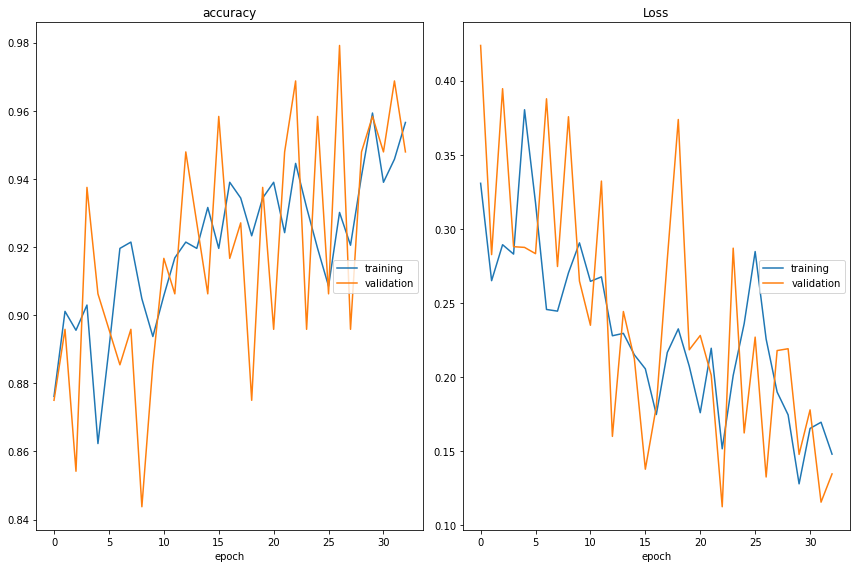

accuracy
	training         	 (min:    0.862, max:    0.959, cur:    0.957)
	validation       	 (min:    0.844, max:    0.979, cur:    0.948)
Loss
	training         	 (min:    0.128, max:    0.380, cur:    0.148)
	validation       	 (min:    0.112, max:    0.424, cur:    0.134)
34/34 [==============================] - 20s 576ms/step - loss: 0.1478 - accuracy: 0.9566 - val_loss: 0.1345 - val_accuracy: 0.9479


In [ ]:
steps_for_each_epoch = train_gen.samples // BATCH_SIZE
validation_steps_for_each_epoch = validation_gen.samples // BATCH_SIZE

OPTIMIZER = Adam(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])

## save model after every epoch ##
checkpointer = ModelCheckpoint(filepath='img_model.trained.weights.hdf5', verbose=1, save_best_only=True)

## Early stopping to stop over training
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

history = model.fit(
    train_gen, 
    epochs=EPOCHS, 
    steps_per_epoch=steps_for_each_epoch,
    validation_data=validation_gen,
    validation_steps=validation_steps_for_each_epoch,
    callbacks=[early_stop, checkpointer, PlotLossesKeras()],
    verbose=True
)


In [ ]:
test_data_gen = ImageDataGenerator(rescale=1/255.)

testgen = test_data_gen.flow_from_directory(
    test_dir,
    target_size=INPUT_SHAPE,
    batch_size=1,
    class_mode=None,
    classes=classes,
    shuffle=False,
    seed=42
)

Found 145 images belonging to 4 classes.


In [ ]:
model.load_weights('img_model.trained.weights.hdf5')
predicted_classes = predictions = np.argmax(model.predict(testgen),axis=1)
class_indices = train_gen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
true_classes = testgen.classes

In [ ]:
def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T

    results.rename(columns={0: 'Precision', 1: 'Recall',
                            2: 'F-Score', 3: 'Support'}, inplace=True)
    
    results.sort_values(by='F-Score', ascending=False, inplace=True)                           
    global_acc = accuracy_score(y_true, y_preds)
    
    print("Overall Categorical Accuracy: {:.2f}%".format(global_acc*100))
    return results

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = y_preds[idx]
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))


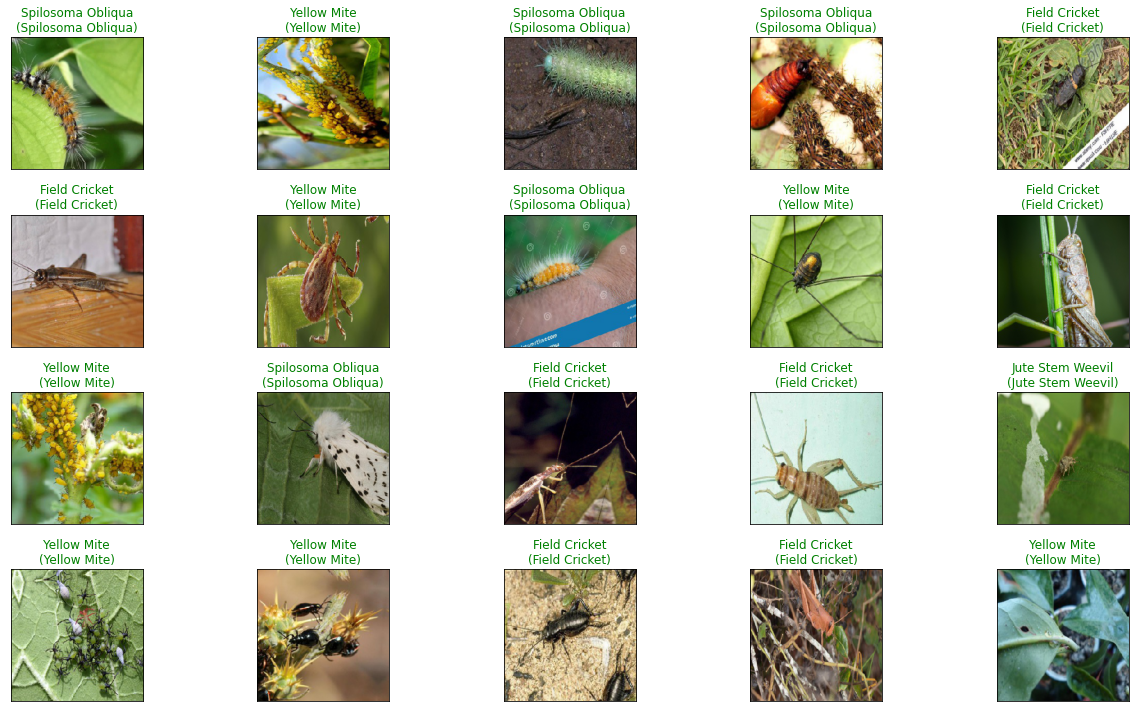

In [ ]:
plot_predictions(true_classes, predicted_classes, testgen, class_indices)

In [ ]:
display_results(true_classes, predicted_classes,class_indices)

Overall Categorical Accuracy: 97.93%


,Precision,Recall,F-Score,Support
3,1.000000,1.000000,1.000000,37.0
2,1.000000,0.948718,0.973684,39.0
1,0.972222,0.972222,0.972222,36.0
0,0.942857,1.000000,0.970588,33.0


In [ ]:
from sklearn.metrics import classification_report 

print(classification_report(true_classes, predicted_classes))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        33
           1       0.97      0.97      0.97        36
           2       1.00      0.95      0.97        39
           3       1.00      1.00      1.00        37

    accuracy                           0.98       145
   macro avg       0.98      0.98      0.98       145
weighted avg       0.98      0.98      0.98       145



97.93103448275862


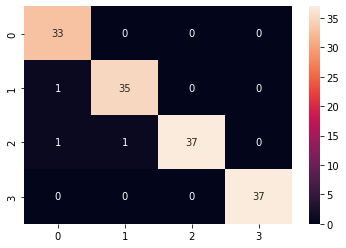

In [ ]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix ,accuracy_score
sns.heatmap(confusion_matrix(true_classes, predicted_classes), annot=True)

print(accuracy_score(true_classes, predicted_classes)*100) 

In [ ]:
print(confusion_matrix(true_classes, predicted_classes))

[[33  0  0  0]
 [ 1 35  0  0]
 [ 1  1 37  0]
 [ 0  0  0 37]]


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8165668191799706239
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14444920832
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10383467669219156652
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
!cat /proc/meminfo


MemTotal:       13297228 kB
MemFree:          213928 kB
MemAvailable:    9803252 kB
Buffers:           96860 kB
Cached:          8131332 kB
SwapCached:            0 kB
Active:          1481736 kB
Inactive:       11012152 kB
Active(anon):       1220 kB
Inactive(anon):  2883216 kB
Active(file):    1480516 kB
Inactive(file):  8128936 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               508 kB
Writeback:             0 kB
AnonPages:       4265868 kB
Mapped:          1754096 kB
Shmem:             15632 kB
KReclaimable:     305796 kB
Slab:             355596 kB
SReclaimable:     305796 kB
SUnreclaim:        49800 kB
KernelStack:        8064 kB
PageTables:        37300 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6648612 kB
Committed_AS:    7331416 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       56620 kB
VmallocChunk:          0 kB
Percpu:          

In [ ]:
len(history.history['loss'])

33